In [3]:
# @title Import Packages

# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

# XGBoost
# !pip install xgboost
from xgboost import XGBClassifier

# Scikit-learn utilities
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Imbalanced-learn for handling imbalanced datasets
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# PyTorch for neural network models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# !pip install torchsummary
from torchsummary import summary

# Progress bar for loops
from tqdm import tqdm

# Google Colab specific (if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# @title Data processing
class Dataset:
    def __init__(self, file_path):
        self.dataset = pd.read_feather(file_path)
        self.original = self.dataset.copy()
        self.X_train, self.y_train = None, None
        self.X_valid, self.y_valid = None, None
        self.X_test, self.y_test = None, None
        self.label = 'loan_condition_cat'
        self.min_max_columns = ['annual_inc', 'year']
        self.means = {}
        self.stds = {}
        self.mins = {}
        self.maxs = {}

    def show(self, rows=10):
        return self.dataset.head(rows)

    def basic_processing(self):
        temp_func_2 = lambda x: {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}[str(x)]
        columns_to_delete = [
            'id', 'issue_d', 'home_ownership_cat', 'income_category', 'income_cat', 'term_cat',
            'application_type_cat', 'purpose_cat', 'interest_payment_cat', 'loan_condition'
        ]
        self.dataset.drop(columns=columns_to_delete, inplace=True)
        self.dataset['grade'] = self.dataset['grade'].apply(temp_func_2)
        self.dataset['final_d'] = self.dataset['final_d'].apply(lambda x: str(x)[-4:]).apply(int)
        self.dataset['year'] = self.dataset['year'].apply(lambda x: str(x)[-4:]).apply(int)
        self.dataset = pd.get_dummies(self.dataset, columns=['home_ownership', 'term', 'application_type',
                                                             'purpose', 'interest_payments', 'region'], dtype=int)

    def train_test_split(self, test_size=0.05, valid_size=0.10, random_state=43142):
        """
        Split the dataset into train, validation, and test sets while ensuring that the
        proportions of the classes remain consistent (stratified sampling).
        """
        # Extract features and target
        X = self.dataset.drop(columns=[self.label])
        y = self.dataset[self.label]

        # Calculate the proportions for splitting
        total_size = len(self.dataset)
        test_size_ratio = test_size / (1 - valid_size)  # Adjust test size ratio after valid split

        # Stratified split for test set
        X_train_valid, self.X_test, y_train_valid, self.y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state
        )

        # Stratified split for validation set from the remaining data
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(
            X_train_valid, y_train_valid, test_size=valid_size / (1 - test_size),
            stratify=y_train_valid, random_state=random_state
        )

        # Save original columns for reference
        self.original_columns = X.columns

        # Sort and reset index for consistency
        for dataset in [self.X_train, self.X_valid, self.X_test, self.y_train, self.y_valid, self.y_test]:
            dataset.sort_index(inplace=True)
            dataset.reset_index(drop=True, inplace=True)

        # Print proportions to verify stratification
        print("Proportions in the original data:")
        print(y.value_counts(normalize=True))
        print("\nProportions in the training set:")
        print(self.y_train.value_counts(normalize=True))
        print("\nProportions in the validation set:")
        print(self.y_valid.value_counts(normalize=True))
        print("\nProportions in the test set:")
        print(self.y_test.value_counts(normalize=True))

    def preprocessing_train(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_train.columns if col not in columns_to_normalize]

        # Z-score normalization
        for col in columns_to_scale:
            mean = np.mean(self.X_train[col])
            std = np.std(self.X_train[col])
            self.means[col] = mean
            self.stds[col] = std
            self.X_train[col] = (self.X_train[col] - mean) / std

        # Min-Max normalization
        for col in columns_to_normalize:
            min_val = np.min(self.X_train[col])
            max_val = np.max(self.X_train[col])
            self.mins[col] = min_val
            self.maxs[col] = max_val
            self.X_train[col] = (self.X_train[col] - min_val) / (max_val - min_val)

        # Perform PCA
        selected_columns = self.perform_pca(self.X_train, n_components=35)
        self.X_train = self.X_train[selected_columns]

    def perform_pca(self, data, n_components):
        # Center the data
        data_mean = np.mean(data, axis=0)
        centered_data = data - data_mean

        # Compute covariance matrix
        cov_matrix = np.cov(centered_data, rowvar=False)

        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Select the top n_components
        selected_eigenvectors = sorted_eigenvectors[:, :n_components]

        # Identify important features
        feature_importance = np.abs(selected_eigenvectors).sum(axis=1)
        important_indices = np.argsort(feature_importance)[::-1][:n_components]

        # Return the original column names of these features
        important_features = [self.original_columns[i] for i in important_indices]

        return important_features

    def preprocessing_test(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_test.columns if col not in columns_to_normalize]

        # Apply Z-score normalization using training statistics
        for col in columns_to_scale:
            self.X_test[col] = (self.X_test[col] - self.means[col]) / self.stds[col]

        # Apply Min-Max normalization using training statistics
        for col in columns_to_normalize:
            self.X_test[col] = (self.X_test[col] - self.mins[col]) / (self.maxs[col] - self.mins[col])

        # Apply PCA using training components
        self.X_test = self.X_test[[i for i in self.X_train.columns.to_list()]]

    def preprocessing_valid(self):
        # Separate columns for Min-Max and Z-score normalization
        columns_to_normalize = self.min_max_columns
        columns_to_scale = [col for col in self.X_valid.columns if col not in columns_to_normalize]

        # Apply Z-score normalization using training statistics
        for col in columns_to_scale:
            self.X_valid[col] = (self.X_valid[col] - self.means[col]) / self.stds[col]

        # Apply Min-Max normalization using training statistics
        for col in columns_to_normalize:
            self.X_valid[col] = (self.X_valid[col] - self.mins[col]) / (self.maxs[col] - self.mins[col])

        # Apply PCA using training components
        self.X_valid = self.X_valid[[i for i in self.X_train.columns.to_list()]]

# Main script
data = Dataset('/content/drive/My Drive/Colab Notebooks/FTEC4998_9/loan_final313_processed.feather')
data.basic_processing()
data.train_test_split(test_size=0.05, valid_size=0.10)
data.preprocessing_train()
data.preprocessing_valid()
data.preprocessing_test()

# Data conversion
train_x, train_y = data.X_train, data.y_train
valid_x, valid_y = data.X_valid, data.y_valid
test_x, test_y = data.X_test, data.y_test

# Ensure y_train, y_valid, and y_test are binary
assert set(train_y).issubset({0, 1}), "Target values for train_y must be 0 or 1 for binary classification."
assert set(valid_y).issubset({0, 1}), "Target values for valid_y must be 0 or 1 for binary classification."
assert set(test_y).issubset({0, 1}), "Target values for test_y must be 0 or 1 for binary classification."

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Proportions in the original data:
loan_condition_cat
0    0.924013
1    0.075987
Name: proportion, dtype: float64

Proportions in the training set:
loan_condition_cat
0    0.924013
1    0.075987
Name: proportion, dtype: float64

Proportions in the validation set:
loan_condition_cat
0    0.924012
1    0.075988
Name: proportion, dtype: float64

Proportions in the test set:
loan_condition_cat
0    0.924024
1    0.075976
Name: proportion, dtype: float64


In [5]:
# @title Some UTILITIES
def plot_inertia(train_x, train_y, max_k):
    """
    Plot inertia (elbow method) to determine the optimal number of clusters for K-Means.

    Parameters:
    - train_x: Training features (numpy array or pandas dataframe).
    - train_y: Training labels (numpy array or pandas series).
    - max_k: Maximum number of clusters to evaluate (default is 10).
    """
    # Filter minority class samples (label == 1)
    minority_x = train_x[train_y == 1]

    # Compute inertia for different values of K
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(minority_x)
        inertia.append(kmeans.inertia_)

    # Plot the inertia plot (elbow method)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='--', color='b')
    plt.title('Inertia Plot (Elbow Method)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.grid()
    plt.show()

def kmeans_smote_balanced_sampled(train_x, train_y, k):
    """
    Perform K-Means-Based SMOTE on the training dataset to balance the label distribution around 50-50,
    and then sample 50% of each label from the final dataset. The result is returned as pandas DataFrame and Series.

    Parameters:
    - train_x: Training features (pandas DataFrame).
    - train_y: Training labels (pandas Series).
    - k: Number of clusters for K-Means.

    Returns:
    - X_sampled_df: 50% sampled training features (pandas DataFrame).
    - y_sampled_df: 50% sampled training labels (pandas Series).
    """
    # Separate majority and minority classes
    majority_x = train_x[train_y == 0].values  # Convert to NumPy for processing
    minority_x = train_x[train_y == 1].values  # Convert to NumPy for processing

    # Step 1: Apply K-Means clustering to the minority class
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(minority_x)

    # Step 2: Generate synthetic samples to balance the dataset
    total_synthetic_samples = len(majority_x) - len(minority_x)  # Number of samples needed
    synthetic_samples = []
    samples_per_cluster = total_synthetic_samples // k  # Distribute samples evenly across clusters
    for cluster in range(k):
        cluster_data = minority_x[clusters == cluster]
        if len(cluster_data) > 1:  # Need at least 2 samples to interpolate
            for _ in range(samples_per_cluster):
                # Randomly pick two points in the cluster
                idx1, idx2 = np.random.choice(len(cluster_data), size=2, replace=False)
                point1, point2 = cluster_data[idx1], cluster_data[idx2]
                # Generate a synthetic sample by interpolation
                synthetic_sample = point1 + np.random.rand() * (point2 - point1)
                synthetic_samples.append(synthetic_sample)

    # Handle any remaining synthetic samples
    remaining_samples = total_synthetic_samples - samples_per_cluster * k
    if remaining_samples > 0:
        cluster_data = minority_x[clusters == 0]  # Use the first cluster as a fallback
        for _ in range(remaining_samples):
            idx1, idx2 = np.random.choice(len(cluster_data), size=2, replace=False)
            point1, point2 = cluster_data[idx1], cluster_data[idx2]
            synthetic_sample = point1 + np.random.rand() * (point2 - point1)
            synthetic_samples.append(synthetic_sample)

    # Combine synthetic samples
    if synthetic_samples:
        synthetic_samples = np.vstack(synthetic_samples)
    else:
        synthetic_samples = np.empty((0, train_x.shape[1]))  # Handle the case with no synthetic samples

    # Step 3: Combine synthetic samples with the original dataset
    X_resampled = np.vstack([train_x.values, synthetic_samples])
    y_resampled = np.hstack([train_y.values, np.ones(len(synthetic_samples), dtype=int)])

    # Step 4: Sample 50% of each label
    majority_indices = np.where(y_resampled == 0)[0]
    minority_indices = np.where(y_resampled == 1)[0]
    majority_sample_size = len(majority_indices) // 2
    minority_sample_size = len(minority_indices) // 2

    sampled_majority_indices = np.random.choice(majority_indices, size=majority_sample_size, replace=False)
    sampled_minority_indices = np.random.choice(minority_indices, size=minority_sample_size, replace=False)

    sampled_indices = np.concatenate([sampled_majority_indices, sampled_minority_indices])
    np.random.shuffle(sampled_indices)  # Shuffle to mix the labels

    X_sampled = X_resampled[sampled_indices]
    y_sampled = y_resampled[sampled_indices]

    # Step 5: Convert back to pandas DataFrame and Series
    X_sampled_df = pd.DataFrame(X_sampled, columns=train_x.columns)  # Use original column names
    y_sampled_df = pd.Series(y_sampled, name=train_y.name)  # Use original target column name

    return X_sampled_df, y_sampled_df

In [6]:
# @title SMOTE

# Assuming `train_x` is a pandas DataFrame and `train_y` is a pandas Series
optimal_k = 25  # Replace with the optimal K from the plot

X_sampled_df, y_sampled_df = kmeans_smote_balanced_sampled(train_x, train_y, k=optimal_k)

# Print the new class distribution
print("Original class distribution:", train_y.value_counts())
print("Resampled class distribution:", y_sampled_df.value_counts())

# Preview the resulting DataFrame
print(X_sampled_df.head())
print(y_sampled_df.head())

Original class distribution: loan_condition_cat
0    696957
1     57315
Name: count, dtype: int64
Resampled class distribution: loan_condition_cat
1    348478
0    348478
Name: count, dtype: int64
   purpose_wedding  purpose_small_business  purpose_home_improvement  \
0        -0.051016               -0.108686                 -0.248596   
1        -0.051016               -0.108686                 -0.248596   
2        -0.051016               -0.108686                 -0.248596   
3        -0.051016               -0.108686                 -0.248596   
4        -0.051016               -0.108686                 -0.248596   

   purpose_car  recoveries  purpose_moving  purpose_educational       dti  \
0    -0.100445    0.123002       -0.078187            -0.021882 -0.623109   
1    -0.100445   -0.111743       -0.078187            -0.021882 -0.556072   
2    -0.100445   -0.111743       -0.078187            -0.021882 -0.250307   
3    -0.100445   -0.111743       -0.078187            -0.02188

In [7]:
# @title Utilities for Torch
# Train, predict, and accuracy functions
# Function to train the model and store the loss trajectory
def train_model_with_loss_and_error_tracking(model, train_x, train_y, valid_x, valid_y):
    """
    Train the model, track the loss, error rate (1 - accuracy), and the number of errors
    at each epoch for both train and validation sets.
    """
    loss_history = []
    train_error_history = []
    valid_error_history = []
    train_errors_count = []
    valid_errors_count = []

    # Convert validation data to tensor format
    valid_x, valid_y = df_to_tensor(valid_x, valid_y)

    # Total number of samples in the training and validation sets
    total_train_samples = len(train_y)
    total_valid_samples = len(valid_y)

    # Loop over the number of epochs
    for epoch in range(model.epochs):
        model.train()  # Set the model to training mode

        # Forward pass on training data
        output = model(train_x)
        loss = model.criterion(output, train_y)

        # Backward pass and optimization
        model.optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        model.optimizer.step()  # Update the weights

        # Save the loss for this epoch
        loss_history.append(loss.item())

        # Calculate training accuracy and number of errors
        train_predictions = (output > 0.5).float()
        train_correct = (train_predictions == train_y).sum().item()  # Number of correct predictions
        train_errors = total_train_samples - train_correct  # Number of errors
        train_error_history.append(1 - (train_correct / total_train_samples))  # Error rate
        train_errors_count.append(train_errors)  # Number of errors in training

        # Calculate validation accuracy and number of errors
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            valid_output = model(valid_x)
            valid_predictions = (valid_output > 0.5).float()
            valid_correct = (valid_predictions == valid_y).sum().item()  # Number of correct predictions
            valid_errors = total_valid_samples - valid_correct  # Number of errors
            valid_error_history.append(1 - (valid_correct / total_valid_samples))  # Error rate
            valid_errors_count.append(valid_errors)  # Number of errors in validation

        # Print loss, error rates, and number of errors every 50 epochs for tracking
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{model.epochs}], Loss: {loss.item():.4f}, '
                  f'Train Error: {train_errors}/{total_train_samples}, '
                  f'Valid Error: {valid_errors}/{total_valid_samples}')

    return loss_history, train_error_history, valid_error_history, train_errors_count, valid_errors_count

def predict_model_pt(model, X): # ok
    if isinstance(X, pd.DataFrame): X = torch.tensor(X.to_numpy(), dtype=torch.float32)  # Convert DataFrame to tensor
    X = X.to(next(model.parameters()).device)
    model.eval()
    with torch.no_grad():
        outputs = model(X).squeeze()
        return (outputs > 0.5).float().cpu().numpy()  # Convert to numpy array for output

def calculate_accuracy_pt(model, X, y, pred=None): # 95% ok
    # Ensure X and y are on the same device as the model

    if str(type(X)) != "<class 'torch.Tensor'>": X, y = df_to_tensor(X, y)

    # Get predictions
    predictions = torch.tensor(predict_model_pt(model, X), dtype=torch.float32).to(device) if pred is None else torch.tensor(pred, dtype=torch.float32).to(device)

    # Ensure predictions and labels are the same shape
    predictions = predictions.squeeze()
    y = y.squeeze()

    # Calculate accuracy
    correct = (predictions == y).sum().item()
    accuracy = correct / len(y)
    return accuracy

# Function to calculate precision, recall, and AUC
def evaluate_metrics(model, X, y):
    # Evaluate precision, recall, and AUC for a given model and dataset.
    # Get the predicted probabilities (before the 0.5 threshold)
    X, y = df_to_tensor(X, y)
    y_proba = model(X).cpu().detach().numpy()

    # Get binary predictions using the threshold of 0.5
    y_pred = (y_proba > 0.5).astype(float)
    y_true = y.cpu().numpy()

    # Calculate precision, recall, and AUC
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    return precision, recall, auc
def print_metrics_horizontally(accuracy, precision, recall, auc):
    # Round the metrics to 5 decimal places
    accuracy = round(accuracy, 5)
    precision = round(precision, 5)
    recall = round(recall, 5)
    auc = round(auc, 5)

    # Create a DataFrame for horizontal display
    metrics_df = pd.DataFrame({
        'Validation Accuracy': [accuracy],
        'Validation Precision': [precision],
        'Validation Recall': [recall],
        'Validation AUC': [auc]
    })
    print(metrics_df.to_string(index=False))
def df_to_tensor(x, y, device=device): # ok
    assert isinstance(x, pd.DataFrame) and isinstance(y, pd.Series), str((type(x), type(y)))
    return (torch.tensor(x.to_numpy(), dtype=torch.float32).to(device),  torch.tensor(y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device))

In [ ]:
print(X_sampled_df.head())
print(y_sampled_df.head())

Epoch [50/600], Loss: 0.3042, Train Error: 94439/696956, Valid Error: 9849/88738
Epoch [100/600], Loss: 0.2916, Train Error: 90287/696956, Valid Error: 9212/88738
Epoch [150/600], Loss: 0.2844, Train Error: 87854/696956, Valid Error: 8894/88738
Epoch [200/600], Loss: 0.2802, Train Error: 86418/696956, Valid Error: 8774/88738
Epoch [250/600], Loss: 0.2776, Train Error: 85583/696956, Valid Error: 8679/88738
Epoch [300/600], Loss: 0.2759, Train Error: 84974/696956, Valid Error: 8595/88738
Epoch [350/600], Loss: 0.2747, Train Error: 84577/696956, Valid Error: 8590/88738
Epoch [400/600], Loss: 0.2737, Train Error: 84312/696956, Valid Error: 8552/88738
Epoch [450/600], Loss: 0.2730, Train Error: 84057/696956, Valid Error: 8528/88738
Epoch [500/600], Loss: 0.2723, Train Error: 83897/696956, Valid Error: 8508/88738
Epoch [550/600], Loss: 0.2717, Train Error: 83751/696956, Valid Error: 8487/88738
Epoch [600/600], Loss: 0.2712, Train Error: 83656/696956, Valid Error: 8457/88738
Accuracy: 0.9047,

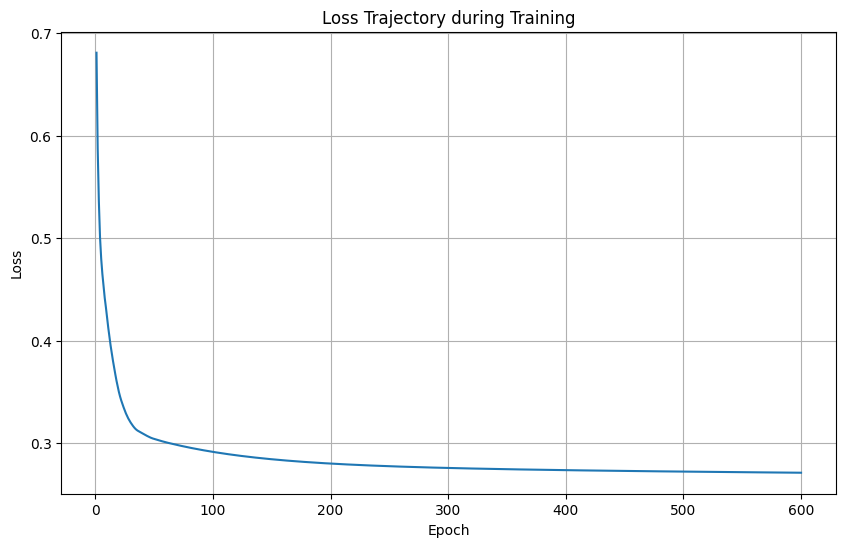

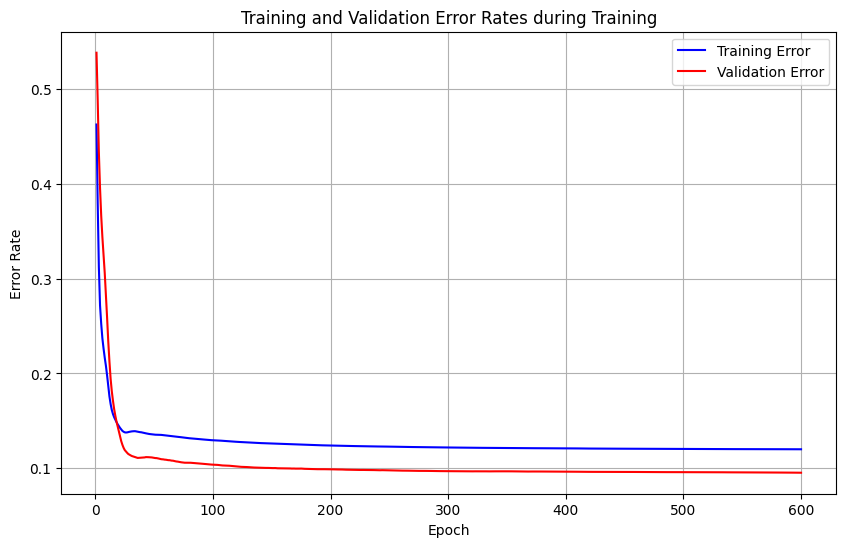

In [ ]:
# @title Logistic Regression
# Define the Logistic Regression model as a simple neural network
class LogisticRegressionModel(nn.Module):
    def __init__(self, train_x, train_y, lr=0.05):
        super(LogisticRegressionModel, self).__init__()

        # Convert training data to tensors and move to the specified device (GPU/CPU)
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)

        # Set input dimension based on the number of features in train_x
        self.input_dim = self.train_x.shape[1]

        # Define the neural network architecture: One Linear layer followed by a Sigmoid activation
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, 1),  # Linear layer mapping input to one output
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

        # Define the loss function (Binary Cross-Entropy) and the optimizer (Adam)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Set the number of training epochs
        self.epochs = 600

    def forward(self, x):
        """
        Forward pass: Compute the output of the network given input x.
        """
        return self.net(x)


# Define the function to print metrics horizontally
def print_metrics_horizontally(accuracy, f_score, auc):
    """
    Prints the metrics in a horizontal format.

    Parameters:
    - accuracy: Validation accuracy.
    - f_score: Validation F-Score.
    - auc: Validation AUC (Area Under the Curve).
    """
    print(f"Accuracy: {accuracy:.4f}, F-Score: {f_score:.4f}, AUC: {auc:.4f}")


# Instantiate the Logistic Regression model
lrg_model = LogisticRegressionModel(X_sampled_df, y_sampled_df)

# Move the model to the specified device (GPU or CPU)
lrg_model.to(device)

# Train the model and track loss trajectory
loss_history, train_error_history, valid_error_history, train_errors_count, valid_errors_count = train_model_with_loss_and_error_tracking(
    lrg_model, lrg_model.train_x, lrg_model.train_y, valid_x, valid_y
)

# Make predictions on the validation set
pred_valid = predict_model_pt(lrg_model, valid_x)

# Calculate validation accuracy
accuracy_valid = calculate_accuracy_pt(lrg_model, valid_x, valid_y, pred_valid)

# Calculate precision, recall, and AUC for the validation set
precision_valid, recall_valid, auc_valid = evaluate_metrics(lrg_model, valid_x, valid_y)

# Calculate F-score using precision and recall
f_score_valid = 2 * (precision_valid * recall_valid) / (precision_valid + recall_valid) if (precision_valid + recall_valid) > 0 else 0.0

# Print validation metrics
print_metrics_horizontally(accuracy_valid, f_score_valid, auc_valid)
print('Valid pred:', pred_valid)

# Plot the loss trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(1, lrg_model.epochs + 1), loss_history, linestyle='-')
plt.title('Loss Trajectory during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot training and validation error rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, lrg_model.epochs + 1), train_error_history, label='Training Error', linestyle='-', color='blue')
plt.plot(range(1, lrg_model.epochs + 1), valid_error_history, label='Validation Error', linestyle='-', color='red')
plt.title('Training and Validation Error Rates during Training')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

Training Model Structure 1
Epoch [50/251], Loss: 0.2970, Train Error: 93722/696956, Valid Error: 11576/88738
Epoch [100/251], Loss: 0.2000, Train Error: 58109/696956, Valid Error: 6581/88738
Epoch [150/251], Loss: 0.1733, Train Error: 51715/696956, Valid Error: 4629/88738
Epoch [200/251], Loss: 0.1633, Train Error: 49868/696956, Valid Error: 4155/88738
Epoch [250/251], Loss: 0.1578, Train Error: 48172/696956, Valid Error: 4071/88738
Accuracy: 0.9542, F-Score: 0.5836, AUC: 0.9361
Accuracy: 0.9542, F-Score: 0.5836, AUC: 0.9361


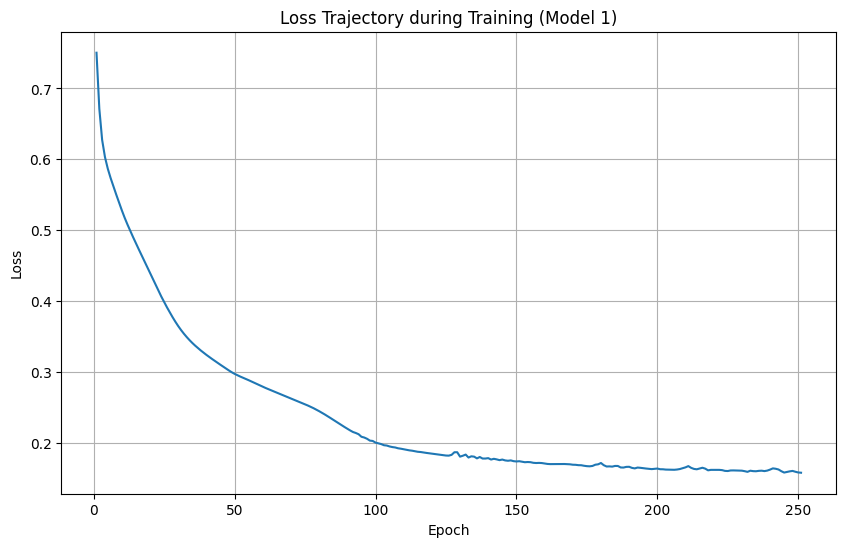

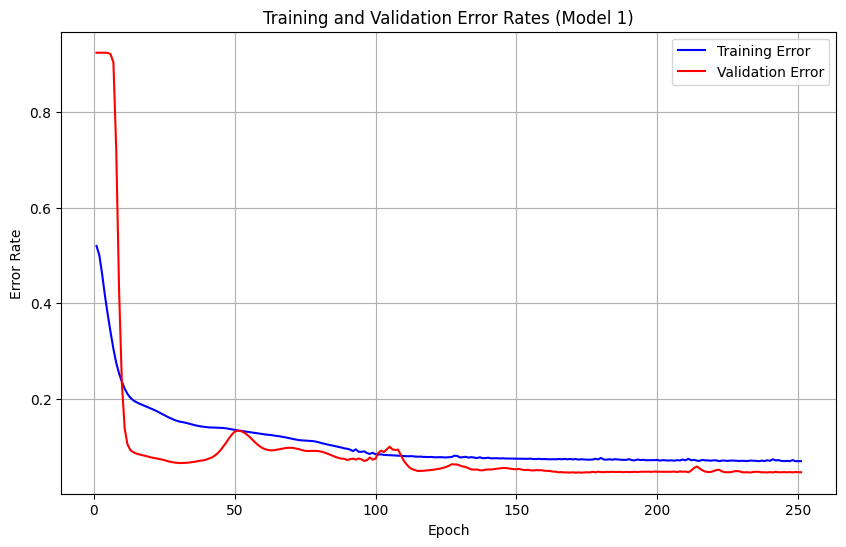

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             576
       BatchNorm1d-2                   [-1, 16]              32
           Sigmoid-3                   [-1, 16]               0
            Linear-4                    [-1, 9]             153
       BatchNorm1d-5                    [-1, 9]              18
              ReLU-6                    [-1, 9]               0
            Linear-7                    [-1, 1]              10
           Sigmoid-8                    [-1, 1]               0
Total params: 789
Trainable params: 789
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Training Model Structure 2
Epoch [50/251], Loss: 0

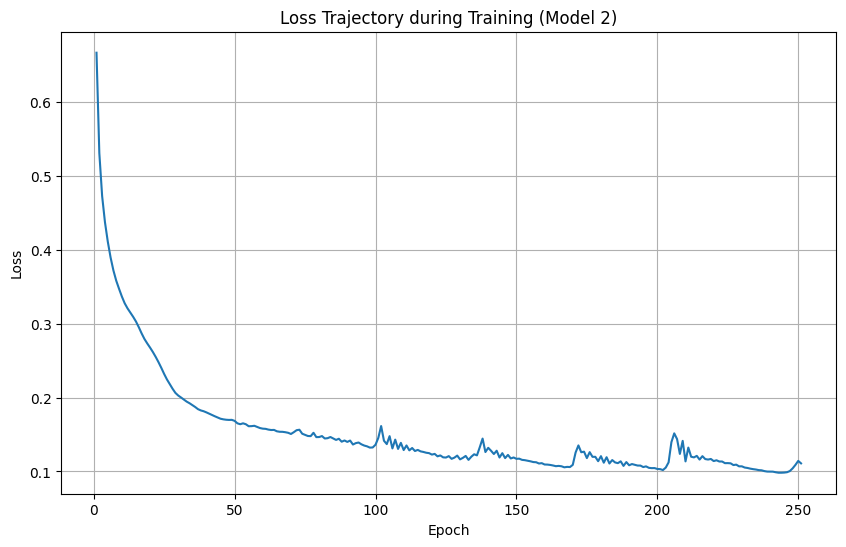

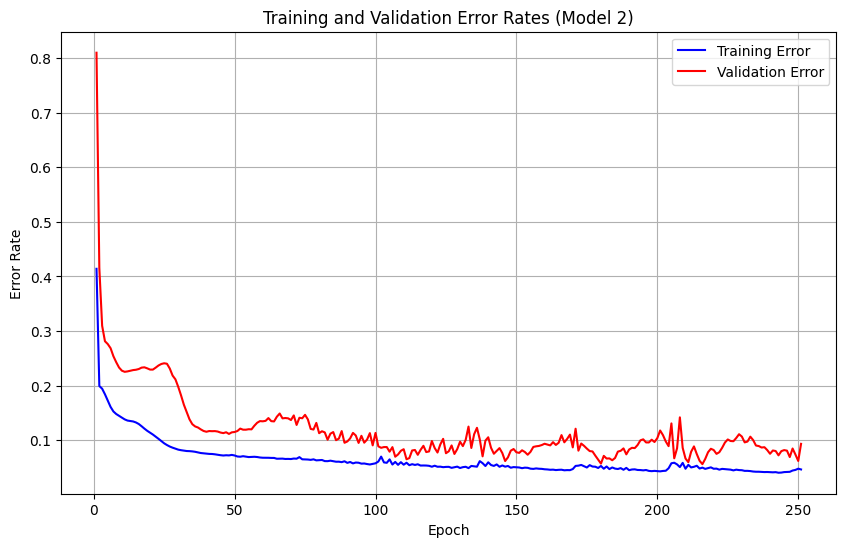

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,304
       BatchNorm1d-2                   [-1, 64]             128
              Tanh-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
       BatchNorm1d-5                   [-1, 32]              64
              ReLU-6                   [-1, 32]               0
            Linear-7                   [-1, 16]             528
       BatchNorm1d-8                   [-1, 16]              32
              Tanh-9                   [-1, 16]               0
           Linear-10                    [-1, 1]              17
          Sigmoid-11                    [-1, 1]               0
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

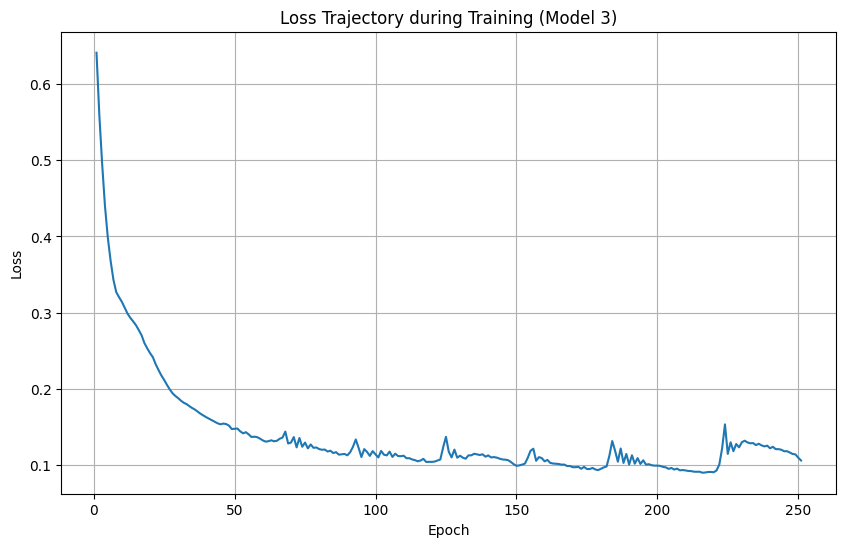

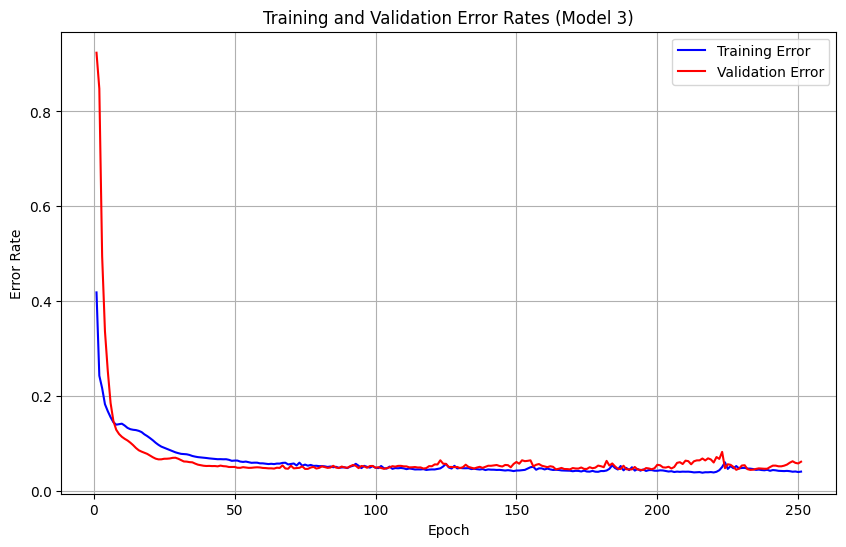

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,608
       BatchNorm1d-2                  [-1, 128]             256
              SiLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
         LeakyReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
       BatchNorm1d-8                   [-1, 32]              64
              SiLU-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 15,425
Trainable params: 15,425
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

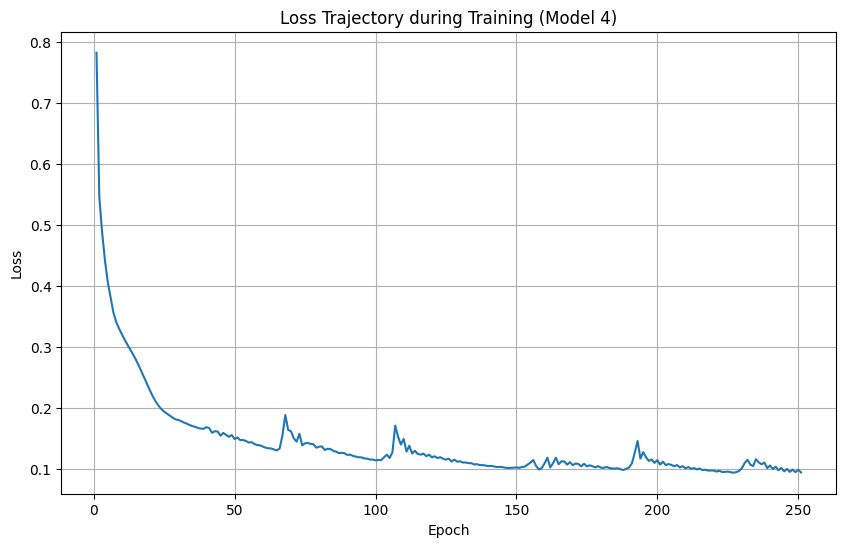

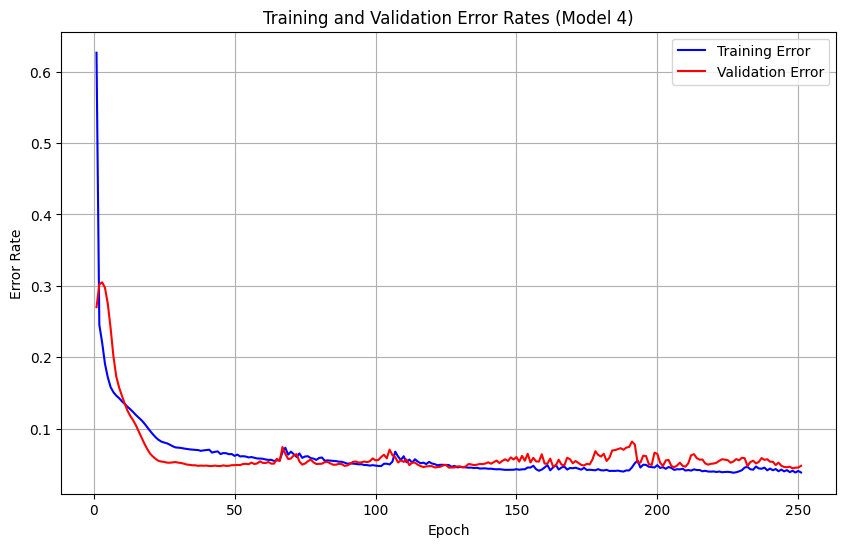

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,608
       BatchNorm1d-2                  [-1, 128]             256
              GELU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
              Tanh-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
       BatchNorm1d-8                   [-1, 32]              64
              Tanh-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
          Sigmoid-11                    [-1, 1]               0
Total params: 15,425
Trainable params: 15,425
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

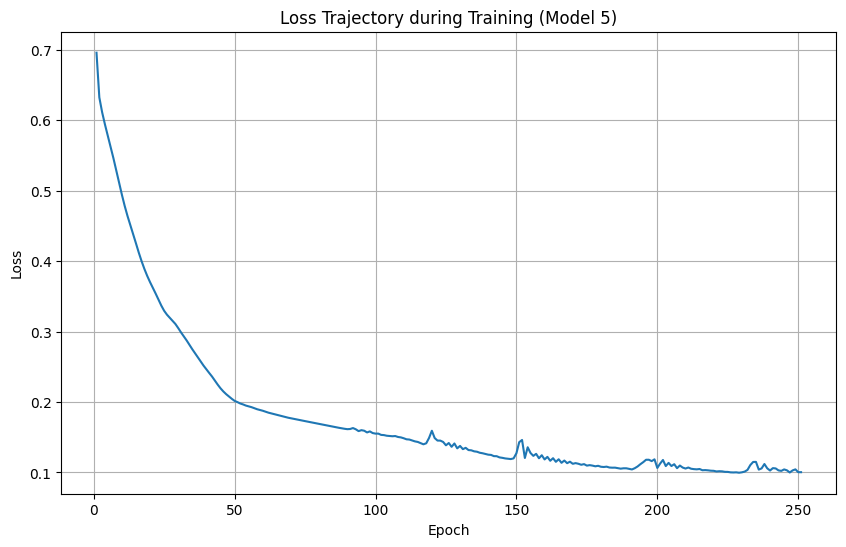

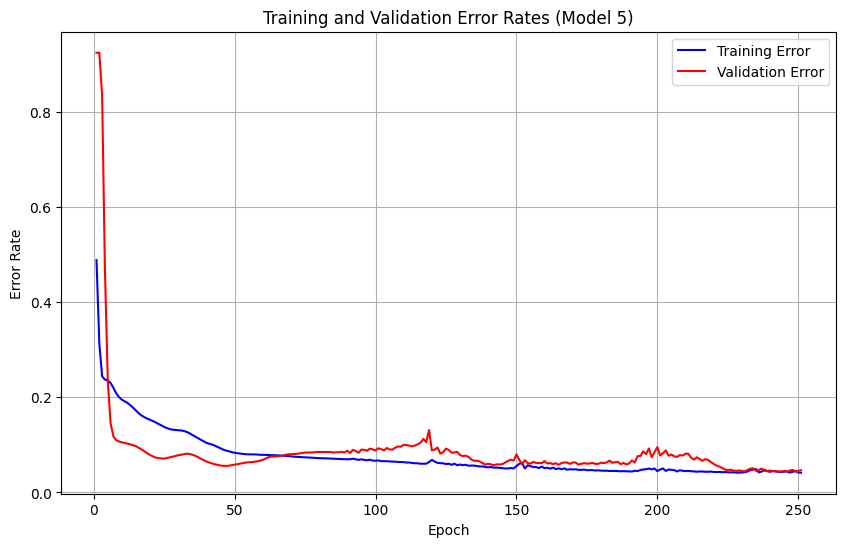

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,152
       BatchNorm1d-2                   [-1, 32]              64
              SiLU-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
          Softplus-6                   [-1, 16]               0
            Linear-7                    [-1, 8]             136
       BatchNorm1d-8                    [-1, 8]              16
              SiLU-9                    [-1, 8]               0
           Linear-10                    [-1, 1]               9
          Sigmoid-11                    [-1, 1]               0
Total params: 1,937
Trainable params: 1,937
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

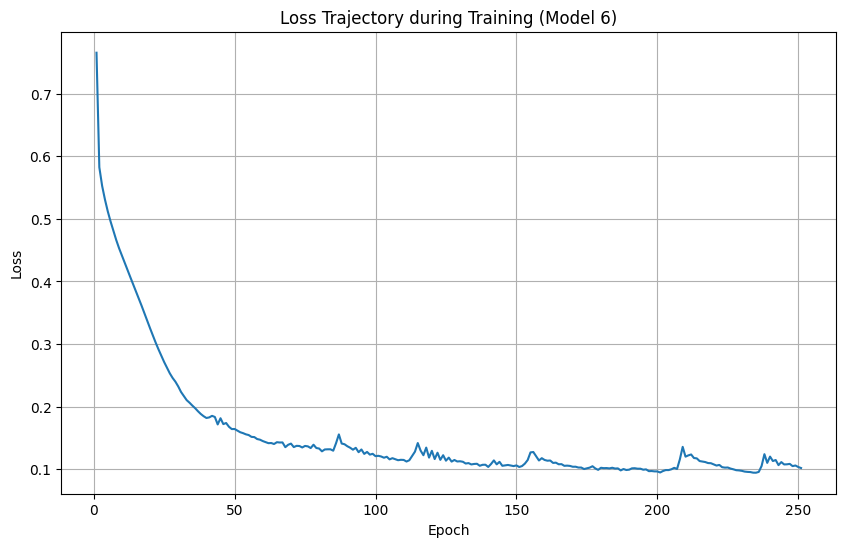

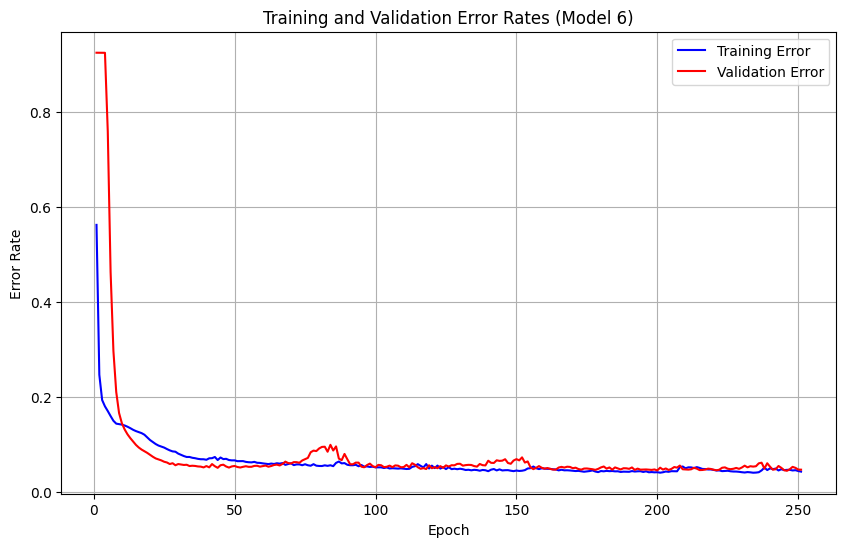

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,304
       BatchNorm1d-2                   [-1, 64]             128
              GELU-3                   [-1, 64]               0
            Linear-4                   [-1, 48]           3,120
       BatchNorm1d-5                   [-1, 48]              96
              ReLU-6                   [-1, 48]               0
            Linear-7                   [-1, 32]           1,568
       BatchNorm1d-8                   [-1, 32]              64
          Softsign-9                   [-1, 32]               0
           Linear-10                   [-1, 16]             528
      BatchNorm1d-11                   [-1, 16]              32
             SELU-12                   [-1, 16]               0
           Linear-13                    [-1, 8]             136
      BatchNorm1d-14                   

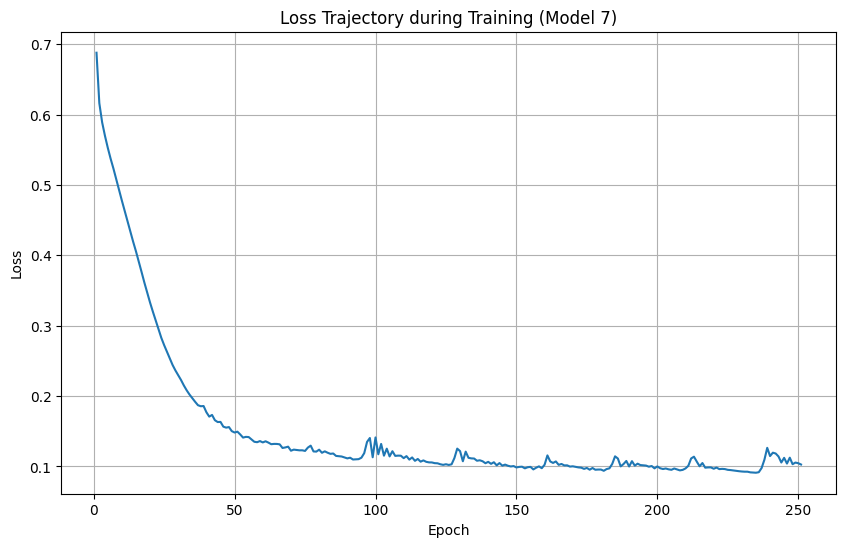

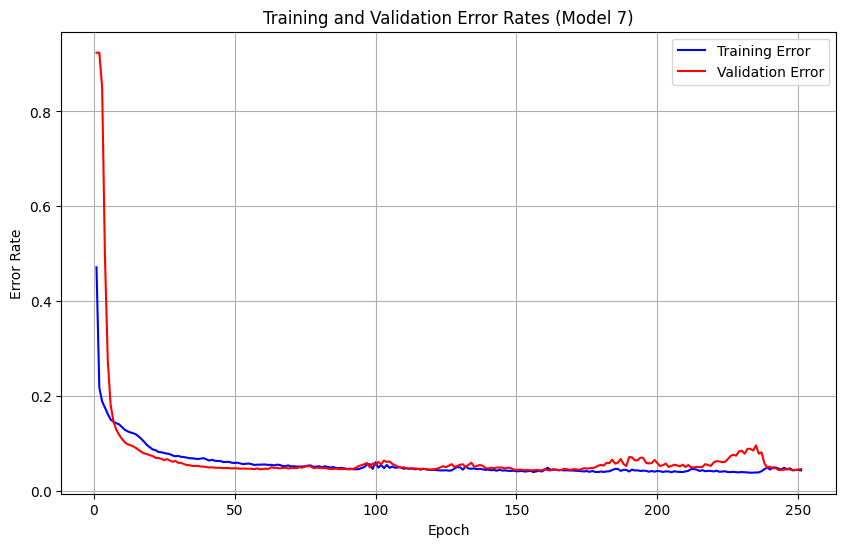

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,304
       BatchNorm1d-2                   [-1, 64]             128
         LeakyReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
       BatchNorm1d-5                   [-1, 32]              64
              SiLU-6                   [-1, 32]               0
            Linear-7                   [-1, 16]             528
       BatchNorm1d-8                   [-1, 16]              32
              Tanh-9                   [-1, 16]               0
           Linear-10                   [-1, 16]             272
      BatchNorm1d-11                   [-1, 16]              32
              ELU-12                   [-1, 16]               0
           Linear-13                    [-1, 8]             136
      BatchNorm1d-14                   

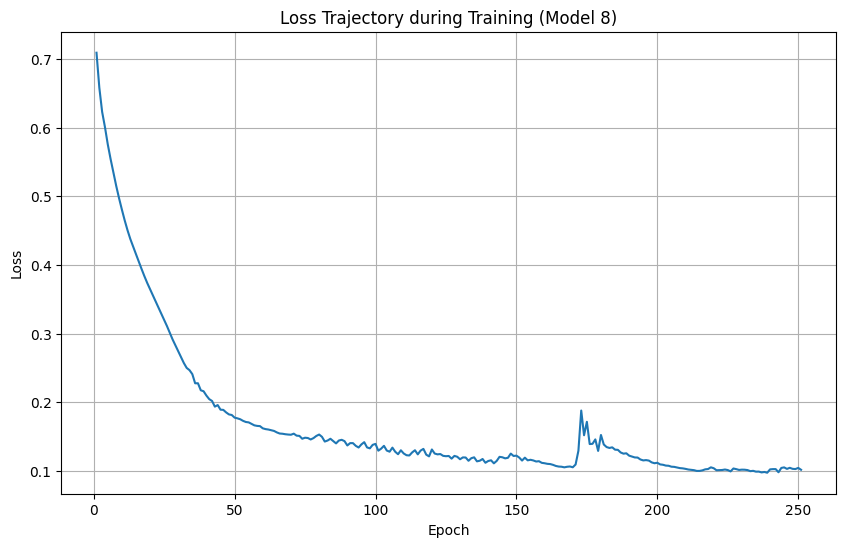

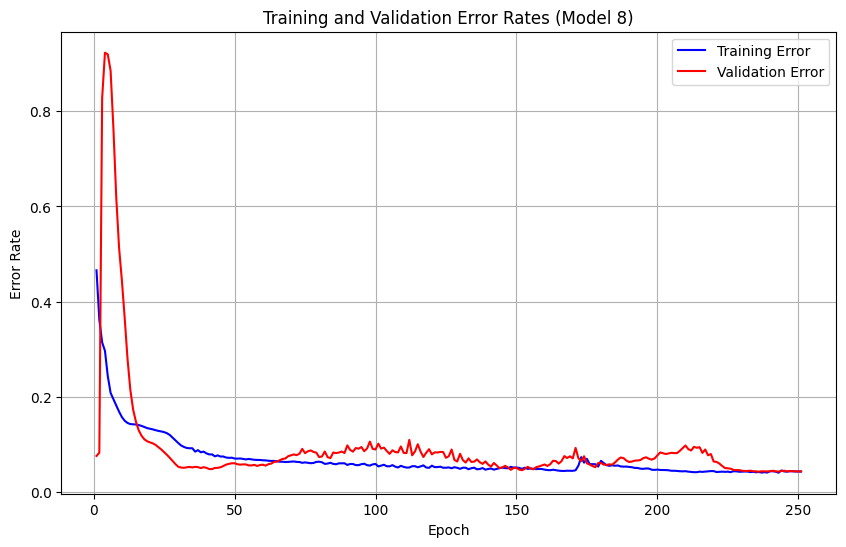

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,304
       BatchNorm1d-2                   [-1, 64]             128
              SiLU-3                   [-1, 64]               0
            Linear-4                   [-1, 48]           3,120
       BatchNorm1d-5                   [-1, 48]              96
          Softplus-6                   [-1, 48]               0
            Linear-7                   [-1, 32]           1,568
       BatchNorm1d-8                   [-1, 32]              64
              SELU-9                   [-1, 32]               0
           Linear-10                   [-1, 16]             528
      BatchNorm1d-11                   [-1, 16]              32
             GELU-12                   [-1, 16]               0
           Linear-13                    [-1, 8]             136
      BatchNorm1d-14                   

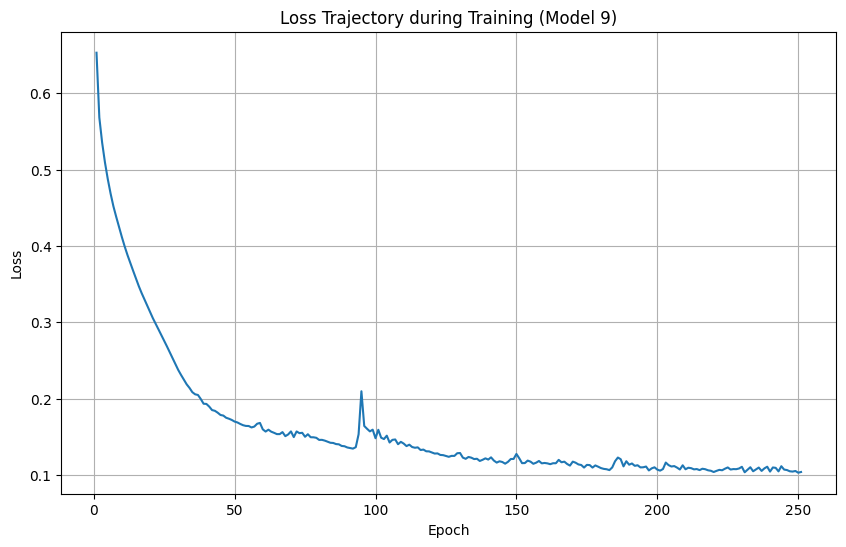

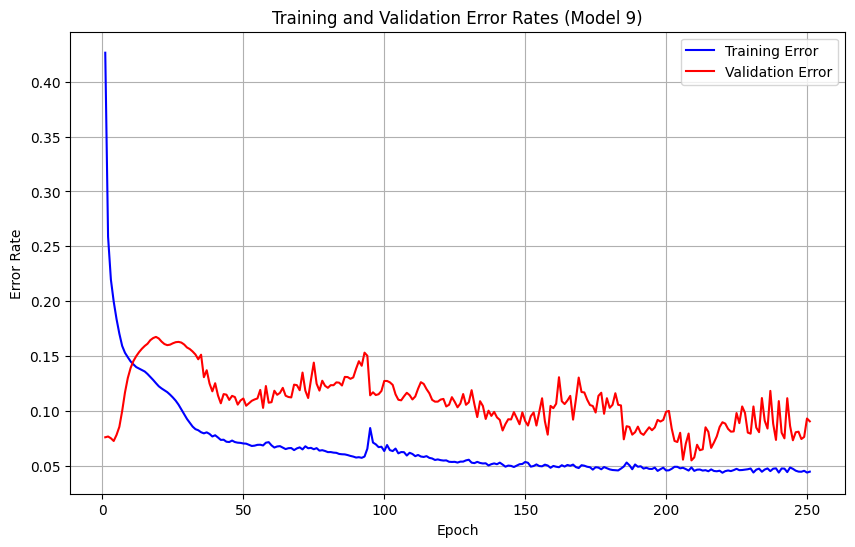

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           2,304
       BatchNorm1d-2                   [-1, 64]             128
               ELU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
       BatchNorm1d-5                   [-1, 32]              64
              ReLU-6                   [-1, 32]               0
            Linear-7                   [-1, 16]             528
       BatchNorm1d-8                   [-1, 16]              32
              Tanh-9                   [-1, 16]               0
           Linear-10                    [-1, 8]             136
      BatchNorm1d-11                    [-1, 8]              16
             SiLU-12                    [-1, 8]               0
           Linear-13                    [-1, 1]               9
          Sigmoid-14                   

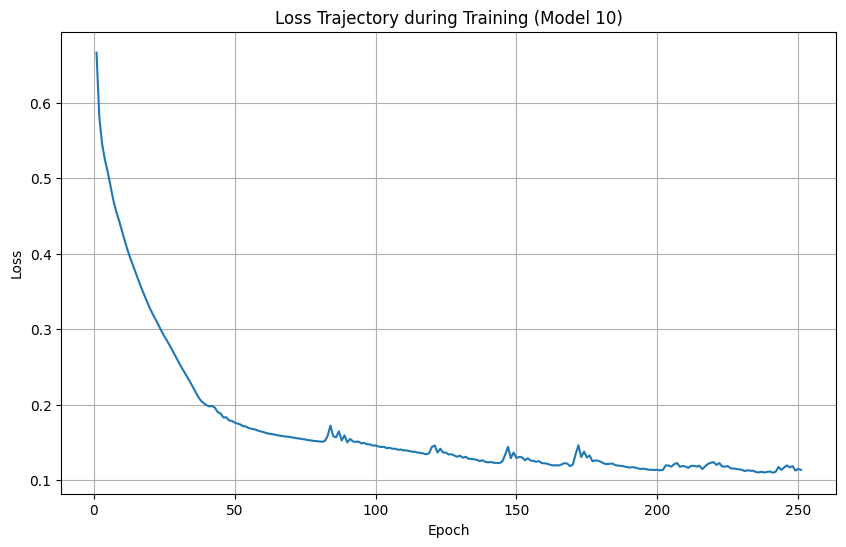

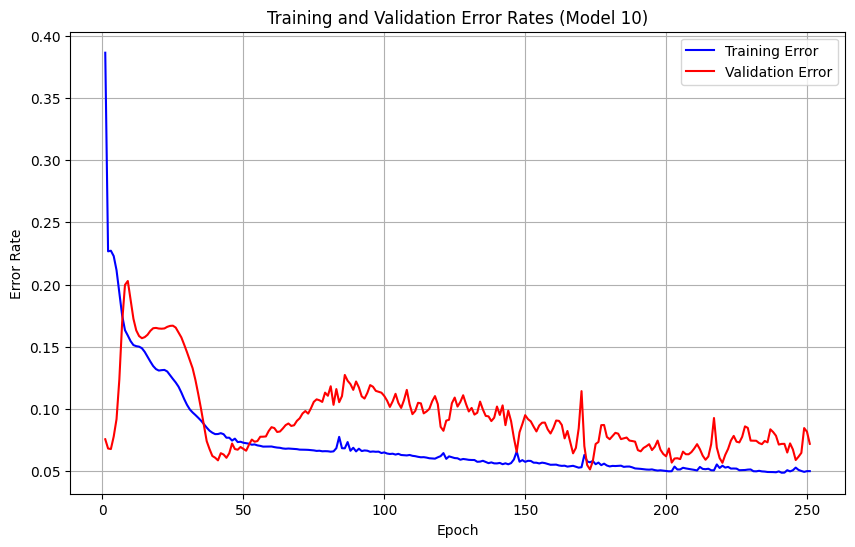

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 48]           1,728
       BatchNorm1d-2                   [-1, 48]              96
              Tanh-3                   [-1, 48]               0
            Linear-4                   [-1, 32]           1,568
       BatchNorm1d-5                   [-1, 32]              64
              GELU-6                   [-1, 32]               0
            Linear-7                   [-1, 16]             528
       BatchNorm1d-8                   [-1, 16]              32
          Softsign-9                   [-1, 16]               0
           Linear-10                    [-1, 8]             136
      BatchNorm1d-11                    [-1, 8]              16
        LeakyReLU-12                    [-1, 8]               0
           Linear-13                    [-1, 1]               9
          Sigmoid-14                   

In [ ]:
# @title DNN
# Define the MLP model for binary classification
class MLPModel(nn.Module):
    def __init__(self, train_x, train_y, lr=0.01, model_num=1):
        super(MLPModel, self).__init__()

        # Convert training data to tensors and move to the specified device (GPU/CPU)
        self.train_y = torch.tensor(train_y.values.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
        self.train_x = torch.tensor(train_x.to_numpy(), dtype=torch.float32).to(device)

        # Set input dimension based on the number of features in train_x
        self.input_dim = self.train_x.shape[1]

        # Define 10 neural network structures
        structures = [
            # Structure 1
            nn.Sequential(
                nn.Linear(self.input_dim, 16),
                nn.BatchNorm1d(16),
                nn.Sigmoid(),
                nn.Linear(16, 9),
                nn.BatchNorm1d(9),
                nn.ReLU(),
                nn.Linear(9, 1),
                nn.Sigmoid()
            ),

            # Structure 2
            nn.Sequential(
                nn.Linear(self.input_dim, 64),
                nn.BatchNorm1d(64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.Tanh(),
                nn.Linear(16, 1),
                nn.Sigmoid()
            ),

            # Structure 3
            nn.Sequential(
                nn.Linear(self.input_dim, 128),
                nn.BatchNorm1d(128),
                nn.SiLU(),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.LeakyReLU(0.1),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.SiLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            ),

            # Structure 4
            nn.Sequential(
                nn.Linear(self.input_dim, 128),
                nn.BatchNorm1d(128),
                nn.GELU(),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.Tanh(),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.Tanh(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            ),

            # Structure 5
            nn.Sequential(
                nn.Linear(self.input_dim, 32),
                nn.BatchNorm1d(32),
                nn.SiLU(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.Softplus(),
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.SiLU(),
                nn.Linear(8, 1),
                nn.Sigmoid()
            ),

            # Structure 6
            nn.Sequential(
                nn.Linear(self.input_dim, 64),
                nn.BatchNorm1d(64),
                nn.GELU(),
                nn.Linear(64, 48),
                nn.BatchNorm1d(48),
                nn.ReLU(),
                nn.Linear(48, 32),
                nn.BatchNorm1d(32),
                nn.Softsign(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.SELU(),
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.SiLU(),
                nn.Linear(8, 1),
                nn.Sigmoid()
            ),

            # Structure 7
            nn.Sequential(
                nn.Linear(self.input_dim, 64),
                nn.BatchNorm1d(64),
                nn.LeakyReLU(0.01),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.SiLU(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.Tanh(),
                nn.Linear(16, 16),
                nn.BatchNorm1d(16),
                nn.ELU(),
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.Softplus(beta=1, threshold=20),
                nn.Linear(8, 1),
                nn.Sigmoid()
            ),

            # Structure 8
            nn.Sequential(
                nn.Linear(self.input_dim, 64),
                nn.BatchNorm1d(64),
                nn.SiLU(),
                nn.Linear(64, 48),
                nn.BatchNorm1d(48),
                nn.Softplus(beta=1, threshold=20),
                nn.Linear(48, 32),
                nn.BatchNorm1d(32),
                nn.SELU(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.LeakyReLU(0.02),
                nn.Linear(8, 1),
                nn.Sigmoid()
            ),

            # Structure 9
            nn.Sequential(
                nn.Linear(self.input_dim, 64),
                nn.BatchNorm1d(64),
                nn.ELU(),
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.Tanh(),
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.SiLU(),
                nn.Linear(8, 1),
                nn.Sigmoid()
            ),

            # Structure 10
            nn.Sequential(
                nn.Linear(self.input_dim, 48),
                nn.BatchNorm1d(48),
                nn.Tanh(),
                nn.Linear(48, 32),
                nn.BatchNorm1d(32),
                nn.GELU(),
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.Softsign(),
                nn.Linear(16, 8),
                nn.BatchNorm1d(8),
                nn.LeakyReLU(0.01),
                nn.Linear(8, 1),
                nn.Sigmoid()
            )
        ]

        # Select the model structure based on model_num
        self.net = structures[model_num - 1]

        # Define the loss function (Binary Cross-Entropy) and the optimizer (Adam)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Set the number of training epochs
        self.epochs = 251

    def forward(self, x):
        """
        Forward pass: Compute the output of the network given input x.
        """
        return self.net(x)

    def show_model_summary(self):
        """
        Displays a detailed summary of the model using torchsummary.
        """
        summary(self, input_size=(self.input_dim,))


# Train and evaluate each of the 10 models
for i in range(1, 11):
    print(f"Training Model Structure {i}")

    # Instantiate the MLP model
    mlp_model = MLPModel(X_sampled_df, y_sampled_df, lr=0.01, model_num=i)

    # Move the model to the specified device (GPU or CPU)
    mlp_model.to(device)

    # Train the model and track loss trajectory
    loss_history, train_error_history, valid_error_history, train_errors_count, valid_errors_count = train_model_with_loss_and_error_tracking(
        mlp_model, mlp_model.train_x, mlp_model.train_y, valid_x, valid_y
    )

    # Make predictions on the validation set
    pred_valid = predict_model_pt(mlp_model, valid_x)

    # Calculate validation accuracy
    accuracy_valid = calculate_accuracy_pt(mlp_model, valid_x, valid_y, pred_valid)

    # Calculate precision, recall, and AUC for the validation set
    precision_valid, recall_valid, auc_valid = evaluate_metrics(mlp_model, valid_x, valid_y)

    # Calculate F-score
    f_score_valid = 2 * (precision_valid * recall_valid) / (precision_valid + recall_valid) if (precision_valid + recall_valid) > 0 else 0.
    # Print validation metrics in the desired format
    print(f"Accuracy: {accuracy_valid:.4f}, F-Score: {f_score_valid:.4f}, AUC: {auc_valid:.4f}")

    # Print validation metrics
    print_metrics_horizontally(accuracy_valid, f_score_valid, auc_valid)

    # Plot the loss trajectory
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, mlp_model.epochs + 1), loss_history, linestyle='-')
    plt.title(f'Loss Trajectory during Training (Model {i})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Plot training and validation error rates
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, mlp_model.epochs + 1), train_error_history, label='Training Error', linestyle='-', color='blue')
    plt.plot(range(1, mlp_model.epochs + 1), valid_error_history, label='Validation Error', linestyle='-', color='red')
    plt.title(f'Training and Validation Error Rates (Model {i})')
    plt.xlabel('Epoch')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Show the model summary using torchsummary
    mlp_model.show_model_summary()

In [9]:
# @title SVM
# Kernels to try
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Define a class for SVM with Bagging as you provided
class SVMClassifier():
    def __init__(self, train_x, train_y, C=1.0, kernel='rbf', n_estimators=5, max_samples=3000, random_state=43):
        self.train_x = train_x
        self.train_y = train_y
        self.C = C
        self.kernel = kernel
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state

    def fit(self):
        rng = np.random.RandomState(self.random_state)
        self.models = []  # Store the individual SVM models

        for i in range(self.n_estimators):
            X_sample, y_sample = resample(self.train_x, self.train_y, n_samples=self.max_samples, random_state=rng)
            model = SVC(C=self.C, kernel=self.kernel, probability=True)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        if not hasattr(self, 'models') or len(self.models) == 0:
            raise ValueError("Model has not been trained yet. Call `fit` before `predict`.")

        predictions = np.array([model.predict(X) for model in self.models])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
        return majority_vote

    def predict_proba(self, X):
        if not hasattr(self, 'models') or len(self.models) == 0:
            raise ValueError("Model has not been trained yet. Call `fit` before `predict_proba`.")

        proba = np.mean([model.predict_proba(X) for model in self.models], axis=0)
        return proba

    def calculate_accuracy(self, X, y):
        pred = self.predict(X)
        return accuracy_score(y, pred)

    def calculate_metrics(self, X, y):
        pred = self.predict(X)
        proba = self.predict_proba(X)[:, 1]  # Probability estimates for the positive class

        accuracy = accuracy_score(y, pred)
        precision = precision_score(y, pred, zero_division=1)
        recall = recall_score(y, pred, zero_division=1)
        auc = roc_auc_score(y, proba)

        return accuracy, precision, recall, auc


# Now, generate 10 random parameter sets and evaluate the model
results = []

for i in range(10):
    print(f"Round {i}")
    # Randomly generate parameters
    C = np.random.uniform(0.1, 10.0)  # Random C between 0.1 and 10
    kernel = np.random.choice(kernels)  # Randomly choose a kernel
    n_estimators = np.random.randint(2, 21)  # Random number of estimators between 1 and 20
    max_samples = np.random.randint(3000, 5000)  # Random max_samples between 1000 and 4999

    # Initialize the classifier with the random parameters
    svm = SVMClassifier(X_sampled_df, y_sampled_df, C=C, kernel=kernel, n_estimators=n_estimators, max_samples=max_samples)

    # Fit the model
    svm.fit()

    # Calculate metrics for the validation set
    accuracy_valid, precision_valid, recall_valid, auc_valid = svm.calculate_metrics(valid_x, valid_y)

    # Store the results
    results.append({
        'C': C,
        'kernel': kernel,
        'n_estimators': n_estimators,
        'max_samples': max_samples,
        'accuracy': accuracy_valid,
        'precision': precision_valid,
        'recall': recall_valid,
        'auc': auc_valid
    })

# Print results for all 20 parameter sets
for idx, result in enumerate(results, 1):
    print(f"Set {idx}:")
    print(f"  C: {result['C']}")
    print(f"  Kernel: {result['kernel']}")
    print(f"  n_estimators: {result['n_estimators']}")
    print(f"  max_samples: {result['max_samples']}")
    print(f"  Accuracy: {round(result['accuracy'], 5)}")
    F1 = round((2 * result['recall'] * result['precision'])/(result['recall'] + result['precision']), 5)
    print(f"  F1-Score{F1}")
    print(f"  AUC: {round(result['auc'], 5)}")
    print("-" * 50)

Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Set 1:
  C: 5.204304323955797
  Kernel: poly
  n_estimators: 19
  max_samples: 3363
  Accuracy: 0.90332
  F1-Score0.12611
  AUC: 0.84209
--------------------------------------------------
Set 2:
  C: 7.446660581016868
  Kernel: poly
  n_estimators: 17
  max_samples: 3380
  Accuracy: 0.90032
  F1-Score0.14268
  AUC: 0.84304
--------------------------------------------------
Set 3:
  C: 4.446453338664419
  Kernel: poly
  n_estimators: 7
  max_samples: 3815
  Accuracy: 0.91047
  F1-Score0.11928
  AUC: 0.84233
--------------------------------------------------
Set 4:
  C: 1.509985707871781
  Kernel: poly
  n_estimators: 5
  max_samples: 3741
  Accuracy: 0.91021
  F1-Score0.08666
  AUC: 0.83793
--------------------------------------------------
Set 5:
  C: 2.278099476940145
  Kernel: rbf
  n_estimators: 20
  max_samples: 3698
  Accuracy: 0.90153
  F1-Score0.44738
  AUC: 0.87711
----------------------------------

In [ ]:
# @title Percetron
# Define the PerceptronModel class
class PerceptronModel():
    def __init__(self,
                 train_x, train_y,
                 max_iter=1000,         # Maximum number of iterations (epochs)
                 eta0=1.0,              # Learning rate (step size)
                 tol=1e-3,              # Tolerance for stopping criteria
                 random_state=42):       # Random state for reproducibility
        """
        Initialize the PerceptronModel with training data and the most important model parameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - max_iter: The maximum number of iterations (epochs).
        - eta0: The learning rate.
        - tol: The tolerance for stopping criteria.
        - random_state: Controls the randomness for reproducibility.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.model = Perceptron(
            max_iter=max_iter,
            eta0=eta0,
            tol=tol,
            random_state=random_state
        )

    def fit(self):
        """Fit the Perceptron model on the training data."""
        self.model.fit(self.train_x, self.train_y)

    def predict(self, X):
        """Predict the labels for the input features X."""
        return self.model.predict(X).astype(float)

    def calculate_metrics(self, X, y):
        """
        Calculate accuracy, F1-score, AUC, and AUC-PR for the given data X and true labels y.

        Parameters:
        - X: Features for prediction.
        - y: True labels.

        Returns:
        - accuracy, f1, auc, auc_pr: The calculated metrics.
        """
        predictions = self.predict(X)
        accuracy = accuracy_score(y, predictions)
        f1 = f1_score(y, predictions, zero_division=0)

        # AUC score requires the predicted probabilities or decision scores
        try:
            decision_scores = self.model.decision_function(X)
            auc = roc_auc_score(y, decision_scores)
            auc_pr = average_precision_score(y, decision_scores)
        except ValueError:
            auc = roc_auc_score(y, predictions)  # Fallback if decision_function is not available
            auc_pr = average_precision_score(y, predictions)

        return accuracy, f1, auc, auc_pr

# Training configurations
configurations = [
    {"max_iter": 1000, "eta0": 0.1, "tol": 1e-3, "random_state": 42},
    {"max_iter": 10000, "eta0": 0.001, "tol": 1e-3, "random_state": 42},
    {"max_iter": 500, "eta0": 0.7, "tol": 1e-3, "random_state": 42},
]

# Placeholder to store the results
results = []

# Loop through each configuration
for i, config in enumerate(configurations):
    print(f"Training model {i + 1} with configuration: {config}")

    # Instantiate the Perceptron Model
    perceptron_model = PerceptronModel(
        X_sampled_df, y_sampled_df,
        max_iter=config["max_iter"],
        eta0=config["eta0"],
        tol=config["tol"],
        random_state=config["random_state"]
    )

    # Fit the model
    perceptron_model.fit()

    # Calculate validation metrics
    accuracy_valid, f1_valid, auc_valid, auc_pr_valid = perceptron_model.calculate_metrics(valid_x, valid_y)

    # Store the results
    results.append({
        "Configuration": config,
        "Accuracy": accuracy_valid,
        "F1-Score": f1_valid,
        "AUC": auc_valid,
        "AUC-PR": auc_pr_valid
    })

    # Print the metrics for the current configuration
    print(f"Results for model {i + 1}:")
    print(f"Accuracy: {accuracy_valid:.4f}, F1-Score: {f1_valid:.4f}, AUC: {auc_valid:.4f}, AUC-PR: {auc_pr_valid:.4f}")
    print("-" * 50)

# Calculate and print average metrics across all configurations
avg_accuracy = np.mean([result["Accuracy"] for result in results])
avg_f1 = np.mean([result["F1-Score"] for result in results])
avg_auc = np.mean([result["AUC"] for result in results])
avg_auc_pr = np.mean([result["AUC-PR"] for result in results])

print("Average Metrics across all configurations:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average AUC: {avg_auc:.4f}")

Training model 1 with configuration: {'max_iter': 1000, 'eta0': 0.1, 'tol': 0.001, 'random_state': 42}
Results for model 1:
Accuracy: 0.8611, F1-Score: 0.4054, AUC: 0.8483, AUC-PR: 0.5417
--------------------------------------------------
Training model 2 with configuration: {'max_iter': 10000, 'eta0': 0.001, 'tol': 0.001, 'random_state': 42}
Results for model 2:
Accuracy: 0.8605, F1-Score: 0.3827, AUC: 0.8200, AUC-PR: 0.5149
--------------------------------------------------
Training model 3 with configuration: {'max_iter': 500, 'eta0': 0.7, 'tol': 0.001, 'random_state': 42}
Results for model 3:
Accuracy: 0.8611, F1-Score: 0.4054, AUC: 0.8483, AUC-PR: 0.5417
--------------------------------------------------
Average Metrics across all configurations:
Average Accuracy: 0.8609
Average F1-Score: 0.3978
Average AUC: 0.8389
Average AUC-PR: 0.5327


In [ ]:
# @title KNN
# Define the KNN Classifier
class KNNClassifier():
    def __init__(self, train_x, train_y, n_neighbors=5):
        """
        Initialize the KNNClassifier with training data and model parameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - n_neighbors: Number of neighbors to use for KNN (default is 5).
        """
        self.train_x = train_x
        self.train_y = train_y
        self.n_neighbors = n_neighbors
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors)

    def fit(self):
        """Fit the KNN model on the training data."""
        self.model.fit(self.train_x, self.train_y)

    def predict(self, X):
        """Predict the labels for the input features X."""
        return self.model.predict(X).astype(float)

    def calculate_metrics(self, X, y):
        """
        Calculate accuracy, precision, recall, and AUC-ROC for the given data X and true labels y.

        Parameters:
        - X: Features for prediction.
        - y: True labels.

        Returns:
        - accuracy, precision, recall, auc_roc: The calculated metrics.
        """
        predictions = self.model.predict(X).astype(float)

        # Get probabilities for the positive class
        probabilities = self.model.predict_proba(X)[:, 1]

        accuracy = accuracy_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        auc_roc = roc_auc_score(y, probabilities)  # Use AUC-ROC instead of AUC-PR

        return accuracy, 2*(precision * recall)/(precision + recall), auc_roc


# Instantiate the KNN Classifier
for i in [50, 60, 70, 80, 90, 100]:
    print(f'i = {i}')
    knn = KNNClassifier(X_sampled_df, y_sampled_df, n_neighbors=i)

    # Fit the model
    knn.fit()

    # Calculate validation metrics (Accuracy, Precision, Recall, AUC-ROC)
    accuracy_valid, F_valid, auc_roc_valid = knn.calculate_metrics(valid_x, valid_y)

    # Print the validation metrics
    print('Validation Accuracy:', round(accuracy_valid, 5))
    print('Validation Precision:', round(F_valid, 5))
    print('Validation AUC-ROC:', round(auc_roc_valid, 5))

i = 50
Validation Accuracy: 0.915
Validation Precision: 0.50844
Validation AUC-ROC: 0.90723
i = 60
Validation Accuracy: 0.9133
Validation Precision: 0.50239
Validation AUC-ROC: 0.90569
i = 70
Validation Accuracy: 0.91186
Validation Precision: 0.49766
Validation AUC-ROC: 0.90435
i = 80
Validation Accuracy: 0.91052
Validation Precision: 0.49252
Validation AUC-ROC: 0.90284
i = 90
Validation Accuracy: 0.90954
Validation Precision: 0.48895
Validation AUC-ROC: 0.90168
i = 100
Validation Accuracy: 0.90831
Validation Precision: 0.48513
Validation AUC-ROC: 0.9005


In [ ]:
# @title Testing 2
class Adaboost():
    def __init__(self, classes_dict, train_x, train_y):
        self.classes_dict = classes_dict
        self.model_order = list(classes_dict.keys())
        self.train_x = train_x
        self.train_y = train_y
        self.trained_model = {}
        self.training_data_history = {'base': {'X': self.train_x, 'y': self.train_y}}
        self.current_weight = None
        self.weight_history = {}
        self.restart = False

    def weight_init(self): self.current_weight = pd.Series(np.ones(len(self.train_y)) / len(self.train_y))

    def weight_calculate(self, predictions, labels):
        incorrect = predictions != labels.to_numpy()
        error_rate = self.current_weight[incorrect].sum()

        print('Error rate is:', error_rate)

        if error_rate > 0.5:
            self.weight_init()
            self.restart = True
            return

        alpha = 0.5 * np.log((1 - error_rate) / error_rate)

        # Update weights
        self.current_weight[incorrect] *= np.exp(alpha)
        self.current_weight[~incorrect] *= np.exp(-alpha)

        # Normalize weights
        self.current_weight /= self.current_weight.sum()

    def training(self):
        self.weight_init()
        for model in self.model_order:
            while True:
                self.restart = False
                self.train_x['weight'] = self.current_weight
                self.train_y = self.train_y.to_frame()
                self.train_y['weight'] = self.current_weight
                sampled_train_x = self.train_x.sample(n=len(self.train_x), replace=True, weights='weight', random_state=42)
                del self.train_x['weight']
                del sampled_train_x['weight']
                sampled_train_x.sort_index(inplace=True)
                sampled_train_x.reset_index(drop=True, inplace=True)
                sampled_train_y = self.train_y.sample(n=len(self.train_y), replace=True, weights='weight', random_state=42)
                del self.train_y['weight']
                self.train_y = self.train_y.iloc[:, 0]
                del sampled_train_y['weight']
                sampled_train_y.sort_index(inplace=True)
                sampled_train_y.reset_index(drop=True, inplace=True)
                sampled_train_y = sampled_train_y.iloc[:, 0]

                print("*" * 37)
                print(f'Training --------------------- {model}')
                current_model = self.classes_dict[model](sampled_train_x, sampled_train_y)
                methods = inspect.getmembers(current_model, predicate=inspect.ismethod)

                if 'fit' in [z for z, _ in methods]:
                    current_model.fit()
                    print('Finish training.\nStart predicting.')
                    current_prediction = current_model.predict(current_model.train_x)
                    train_accuracy = current_model.calculate_accuracy(current_model.train_x , current_model.train_y, current_prediction)
                else:
                    current_model.to(device)
                    train_model_pt(current_model)
                    print('Finish training.\nStart predicting.')
                    current_prediction = predict_model_pt(current_model, current_model.train_x)
                    train_accuracy = calculate_accuracy_pt(current_model, current_model.train_x, current_model.train_y, current_prediction)

                print(f'{model} training accuracy:', train_accuracy)
                self.weight_calculate(current_prediction, sampled_train_y)

                if not self.restart:
                    self.train_x, self.train_y = sampled_train_x, sampled_train_y
                    self.training_data_history[model] = {'X': sampled_train_x, 'y': sampled_train_y}
                    self.trained_model[model] = current_model
                    break
    def reorder(self, order_list): self.model_order = order_list

    def predict(self, X):
        # Ensure X is a pandas DataFrame
        assert isinstance(X, pd.DataFrame), "Input X should be a pandas DataFrame"
        # Collect predictions from each trained model
        model_predictions = {}
        for model_name, model in self.trained_model.items():
            methods = inspect.getmembers(model, predicate=inspect.ismethod)
            if 'predict' in [z for z, _ in methods]: preds = model.predict(X)
            else: preds = predict_model_pt(model, torch.tensor(X.to_numpy(), dtype=torch.float32).to(device))
            assert isinstance(preds, np.ndarray), f"Predictions from {model_name} should be a numpy array"
            if not np.array_equal(np.unique(preds), [0, 1]):
                print('Alert --- ', np.unique(preds))
                preds = np.where(preds > 0.5, 1, 0)
            model_predictions[model_name] = preds
        # Voting mechanism
        predictions = np.zeros(len(X))
        for i in range(len(X)):
            votes = {}
            for model_name, preds in model_predictions.items():
                pred = preds[i]
                if pred in votes: votes[pred] += 1
                else: votes[pred] = 1
            predictions[i] = max(votes, key=votes.get)
        assert isinstance(predictions, np.ndarray), "Final predictions should be a numpy array"
        return predictions

    def calculate_accuracy(self, X, y, pred=None):
        preds = pred if pred is not None else self.predict(X)
        assert isinstance(preds, np.ndarray), "Predictions should be a numpy array"
        assert isinstance(y, pd.Series), "y should be a pandas Series"
        assert len(pred) == len(y), "Predictions and y should have the same length"
        accuracy = np.mean(preds == y.to_numpy())
        return accuracy
adModel = Adaboost(classes_dict={"tabpfn":TabPFNBagging , "lr": LogisticRegressionModel, "svm": SVMClassifier, "ann": ANN, "nb": NaiveBayesClassifier, "rf": RandomForestModel, "xgb": XGBoostClassifier}, train_x=train_x, train_y=train_y)
adModel.reorder(['svm', 'xgb', 'ann', 'rf', 'tabpfn'])
adModel.training()
print("*" * 37)
train_predict = adModel.predict(train_x)
train_acc = adModel.calculate_accuracy(train_x, train_y, train_predict)
test_predict = adModel.predict(test_x)
test_acc = adModel.calculate_accuracy(test_x, test_y, test_predict)
print("Adaboost model prediction: ", train_predict)
print("Adaboost model training accuracy: ", train_acc)
print("Adaboost model prediction: ", test_predict)
print("Adaboost model training accuracy: ", test_acc)

In [ ]:
# @title Kolmogorov-Arnold Network (KAN)
# Define the Kolmogorov-Arnold Network Classifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

class KolmogorovArnoldNetwork():
    def __init__(self, train_x, train_y, hidden_units=10, learning_rate=0.01, epochs=100):
        """
        Initialize the KolmogorovArnoldNetwork with training data and model parameters.

        Parameters:
        - train_x: Features for training.
        - train_y: Labels for training.
        - hidden_units: Number of hidden units in the network.
        - learning_rate: Learning rate for gradient descent.
        - epochs: Number of training epochs.
        """
        self.train_x = train_x
        self.train_y = train_y
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Normalize the data
        self.scaler = MinMaxScaler()
        self.train_x = self.scaler.fit_transform(train_x)

        # Initialize weights and biases
        self.weights_hidden = np.random.randn(self.train_x.shape[1], self.hidden_units)
        self.bias_hidden = np.random.randn(self.hidden_units)
        self.weights_output = np.random.randn(self.hidden_units)
        self.bias_output = np.random.randn(1)

    def activation_function(self, x):
        """Activation function (ReLU)."""
        return np.maximum(0, x)

    def activation_derivative(self, x):
        """Derivative of the activation function (ReLU)."""
        return (x > 0).astype(float)

    def fit(self):
        """Train the Kolmogorov-Arnold Network using gradient descent."""
        for epoch in range(self.epochs):
            # Forward pass
            hidden_layer_input = np.dot(self.train_x, self.weights_hidden) + self.bias_hidden
            hidden_layer_output = self.activation_function(hidden_layer_input)
            output_layer_input = np.dot(hidden_layer_output, self.weights_output) + self.bias_output
            predictions = 1 / (1 + np.exp(-output_layer_input))  # Sigmoid activation for binary classification

            # Compute loss (binary cross-entropy)
            loss = -np.mean(self.train_y * np.log(predictions + 1e-8) + (1 - self.train_y) * np.log(1 - predictions + 1e-8))

            # Backpropagation
            output_error = predictions - self.train_y
            hidden_error = np.dot(output_error, self.weights_output.T) * self.activation_derivative(hidden_layer_input)

            # Update weights and biases
            self.weights_output -= self.learning_rate * np.dot(hidden_layer_output.T, output_error) / self.train_x.shape[0]
            self.bias_output -= self.learning_rate * np.mean(output_error, axis=0)
            self.weights_hidden -= self.learning_rate * np.dot(self.train_x.T, hidden_error) / self.train_x.shape[0]
            self.bias_hidden -= self.learning_rate * np.mean(hidden_error, axis=0)

            # Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch} - Loss: {loss}")

    def predict(self, X):
        """Predict the labels for the input features X."""
        X = self.scaler.transform(X)  # Normalize input data
        hidden_layer_input = np.dot(X, self.weights_hidden) + self.bias_hidden
        hidden_layer_output = self.activation_function(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, self.weights_output) + self.bias_output
        predictions = 1 / (1 + np.exp(-output_layer_input))  # Sigmoid activation for binary classification
        return (predictions > 0.5).astype(float)

    def calculate_metrics(self, X, y):
        """
        Calculate accuracy, precision, recall, and AUC-ROC for the given data X and true labels y.

        Parameters:
        - X: Features for prediction.
        - y: True labels.

        Returns:
        - accuracy, precision, recall, auc_roc: The calculated metrics.
        """
        X = self.scaler.transform(X)  # Normalize input data
        hidden_layer_input = np.dot(X, self.weights_hidden) + self.bias_hidden
        hidden_layer_output = self.activation_function(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, self.weights_output) + self.bias_output
        probabilities = 1 / (1 + np.exp(-output_layer_input))  # Sigmoid activation for binary classification
        predictions = (probabilities > 0.5).astype(float)

        accuracy = accuracy_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        auc_roc = roc_auc_score(y, probabilities)

        return accuracy, 2 * (precision * recall) / (precision + recall), auc_roc


# Instantiate the Kolmogorov-Arnold Network
for hidden_units in [5, 10, 15, 20]:
    print(f"Hidden Units = {hidden_units}")
    kan = KolmogorovArnoldNetwork(train_x=X_sampled_df, train_y=y_sampled_df, hidden_units=hidden_units)

    # Fit the model
    kan.fit()

    # Calculate validation metrics (Accuracy, F1-Score, AUC-ROC)
    accuracy_valid, F_valid, auc_roc_valid = kan.calculate_metrics(valid_x, valid_y)

    # Print the validation metrics
    print('Validation Accuracy:', round(accuracy_valid, 5))
    print('Validation F1-Score:', round(F_valid, 5))
    print('Validation AUC-ROC:', round(auc_roc_valid, 5))